#__ANM-NCPOP__
Define a function for solving the NCPO problems with given standard deviations of process noise and observtion noise, length of  estimation data and required relaxation level.

* Generate the artificial data or standardized observational data.
* Learn the Causal Structure beneath the observation data.
* Visualize the comparison of estimated/true graphs using a heat map.
* Calculate Metrics.
* Demonstrate the performance of method ANM-NCPOP in a heatmap.

**Flow**

Class NCPOLR: Functions generate_operators, estimate

Class ANM_NCPO: Functions learn, ANMNCPO_fitness

                                                      [Input raw data]
                                                              ↓
                                                    <generate_operators>
                                                              |
                                                              | Generate Operators
                                                              ↓
                                                  <estimate or estimate2>
                                                              |
                                                              | Solve NCPOLR problem
                                                              ↓
                        [Output DAG] <--- <learn> <--- <ANMNCPO_fitness>

#__Step 1: Get start__


* mount drive
* set envirment
* install packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/NCPOP-Colab Notebooks/Test_Causality_Datasets/Real_data/Krebs_Cycle/")
# os.chdir("/content/drive/MyDrive/Colab Notebooks/NCPOP-Colab Notebooks/Test_Causality_Datasets/Real_data/Krebs_Cycle/Details_Krebs_Cycle/MetricsDAG/")


Mounted at /content/drive


In [2]:
!export PYTHONPATH="$PYTHONPATH:/content/drive/MyDrive/Colab Notebooks/NCPOP-Colab Notebooks"
import os
os.environ['MOSEKLM_LICENSE_FILE']="/content/drive/MyDrive/Colab Notebooks"

In [3]:
### for colab ###
# To execute the notebook directly in colab make sure your MOSEK license file is in one the locations
#
# /content/mosek.lic   or   /root/mosek/mosek.lic
#
# inside this notebook's internal filesystem.
# Install MOSEK and ncpol2sdpa if not already installed
!pip install mosek torch
!pip install ncpol2sdpa
# !pip install networkx
!pip install gcastle==1.0.3rc2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 25.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

#__Step 2: NCPOLR__

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from itertools import combinations
from castle.common import BaseLearner, Tensor
from castle.common.independence_tests import hsic_test
# from inputlds import*
# from functions import*
from ncpol2sdpa import*
from math import sqrt


class NCPOLR(object):
    """Estimator based on NCPOP Regressor

    References
    ----------
    Quan Zhou https://github.com/Quan-Zhou/Proper-Learning-of-LDS/blob/master/ncpop/functions.py

    Examples
    --------
    """

    def __init__(self, **kwargs):
        super(NCPOLR, self).__init__()


    def generate_operators(name, n_vars=1, hermitian=None, commutative=False):
        """Generates a number of commutative or noncommutative operators

        :param name: The prefix in the symbolic representation of the noncommuting
                    variables. This will be suffixed by a number from 0 to
                    n_vars-1 if n_vars > 1.
        :type name: str.
        :param n_vars: The number of variables.
        :type n_vars: int.
        :param hermitian: Optional parameter to request Hermitian variables .
        :type hermitian: bool.
        :param commutative: Optional parameter to request commutative variables.
                            Commutative variables are Hermitian by default.
        :type commutative: bool.

        :returns: list of :class:`sympy.physics.quantum.operator.Operator` or
                  :class:`sympy.physics.quantum.operator.HermitianOperator`
                  variables

        :Example:

        >>> generate_variables('y', 2, commutative=True)
        ￼[y0, y1]
        """

        variables = []
        for i in range(n_vars):
            if n_vars > 1:
                var_name = '%s%s' % (name, i)
            else:
                var_name = '%s' % name
            if hermitian is not None and hermitian:
                variables.append(HermitianOperator(var_name))
            else:
                variables.append(Operator(var_name))
            variables[-1].is_commutative = commutative
        return variables

    def estimate(self, X, Y):
        """Fit Estimator based on NCPOP Regressor model and predict y or produce residuals.
        The module converts a noncommutative optimization problem provided in SymPy
        format to an SDPA semidefinite programming problem.

        Parameters
        ----------
        X : array
            Variable seen as cause
        Y: array
            Variable seen as effect

        Returns
        -------
        y_predict: array
            regression predict values of y or residuals
        """

        T = len(Y)
        level = 1

        # Decision Variables
        G = generate_operators("G", n_vars=1, hermitian=True, commutative=False)[0]
        f = generate_operators("f", n_vars=T, hermitian=True, commutative=False)
        n = generate_operators("m", n_vars=T, hermitian=True, commutative=False)
        p = generate_operators("p", n_vars=T, hermitian=True, commutative=False)

        # Objective
        obj = sum((Y[i]-f[i])**2 for i in range(T)) + 0.00005*sum(p[i] for i in range(T))

        # Constraints
        ine1 = [f[i] - G*X[i] - n[i] for i in range(T)]
        ine2 = [-f[i] + G*X[i] + n[i] for i in range(T)]
        ine3 = [p[i]-n[i] for i in range(T)]
        ine4 = [p[i]+n[i] for i in range(T)]
        ines = ine1+ine2+ine3+ine4

        # Solve the NCPO
        sdp = SdpRelaxation(variables = flatten([G,f,n,p]),verbose = 1)
        sdp.get_relaxation(level, objective=obj, inequalities=ines)
        sdp.solve(solver='mosek')
        #sdp.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:/Users/zhouq/Documents/sdpa7-windows/sdpa.exe"})
        print(sdp.primal, sdp.dual, sdp.status)

        if(sdp.status != 'infeasible'):
            print('ok.')
            est_noise = []
            for i in range(T):
                est_noise.append(sdp[n[i]])
            print(est_noise)
            return est_noise
        else:
            print('Cannot find feasible solution.')
            return

    def estimate2(self, X, Y):
        """Fit Estimator based on NCPOP Regressor model and predict y or produce residuals.
        The module converts a noncommutative optimization problem provided in SymPy
        format to an SDPA semidefinite programming problem.

        Parameters
        ----------
        Y: array
            Variable seen as effect

        Returns
        -------
        y_predict: array
            regression predict values of y or residuals
        """
        Y = np.transpose(Y)
        T = len(Y)-1
        level = 1


        # Decision Variables
        G = generate_operators("G", n_vars=1, hermitian=True, commutative=False)[0]
        Fdash = generate_operators("Fdash", n_vars=1, hermitian=True, commutative=False)[0]
        # m = generate_operators("m", n_vars=T+1, hermitian=True, commutative=False)
        q = generate_operators("q", n_vars=T, hermitian=True, commutative=False)
        p = generate_operators("p", n_vars=T, hermitian=True, commutative=False)
        f = generate_operators("f", n_vars=T, hermitian=True, commutative=False)

        # Objective
        obj = sum((Y[i]-f[i])**2 for i in range(T)) + 0.0005*sum(p[i]**2 for i in range(T)) + 0.001*sum(q[i]**2 for i in range(T))

        #c1*sum(p[i]**2 for i in range(T)) + c2*sum(q[i]**2 for i in range(T))

        # Constraints
        ine1 = [f[i] - Fdash*X[i+1] - p[i] for i in range(T)]
        ine2 = [-f[i] + Fdash*X[i+1] + p[i] for i in range(T)]
        ine3 = [X[i+1] - G*X[i] - q[i] for i in range(T)]
        ine4 = [-X[i+1] + G*X[i] + q[i] for i in range(T)]
        #ine5 = [(Y[i]-f[i])**2 for i in range(T)]
        ines = ine1+ine2+ine3+ine4 #+ine5

        # Solve the NCPO
        sdp = SdpRelaxation(variables = flatten([G,Fdash,f,p,q]),verbose = 1)
        sdp.get_relaxation(level, objective=obj, inequalities=ines)
        sdp.solve(solver='mosek')

        #sdp.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:/Users/zhouq/Documents/sdpa7-windows/sdpa.exe"})
        print(sdp.primal, sdp.dual, sdp.status)

        if(sdp.status != 'infeasible'):
            print('ok.')
            est_noise = []
            for i in range(T):
                est_noise.append(sdp[p[i]])
            print(est_noise)
            return est_noise, X[1:]
        else:
            print('Cannot find feasible solution.')
            return


In [7]:
from sympy.physics.quantum import HermitianOperator, Operator
y= NCPOLR().generate_operators('y', 2, commutative=True)
y

TypeError: 'str' object cannot be interpreted as an integer

#__Step 3: ANM_NCPO__

In [5]:
class ANM_NCPO(BaseLearner):
    """
    Nonlinear causal discovery with additive noise models

    Use Estimator based on NCPOP Regressor and independent Gaussian noise,
    For the independence test, we implemented the HSIC with a Gaussian kernel,
    where we used the gamma distribution as an approximation for the
    distribution of the HSIC under the null hypothesis of independence
    in order to calculate the p-value of the test result.

    References
    ----------
    Hoyer, Patrik O and Janzing, Dominik and Mooij, Joris M and Peters,
    Jonas and Schölkopf, Bernhard,
    "Nonlinear causal discovery with additive noise models", NIPS 2009

    Parameters
    ----------
    alpha : float, default 0.05
        significance level be used to compute threshold

    Attributes
    ----------
    causal_matrix : array like shape of (n_features, n_features)
        Learned causal structure matrix.

    Examples
    --------
    """

    def __init__(self, alpha=0.05):
        super(ANM_NCPO, self).__init__()
        self.alpha = alpha

    def learn(self, data, columns=None, regressor=NCPOLR(),test_method=hsic_test, **kwargs):
        """Set up and run the ANM_NCPOP algorithm.

        Parameters
        ----------
        data: numpy.ndarray or Tensor
            Training data.
        columns : Index or array-like
            Column labels to use for resulting tensor. Will default to
            RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
        regressor: Class
            Nonlinear regression estimator, if not provided, it is NCPOLR.
            If user defined, must implement `estimate` self.method. such as :
                `regressor.estimate(x, y)`
        test_method: callable, default test_method
            independence test self.method, if not provided, it is HSIC.
            If user defined, must accept three arguments--x, y and keyword
            argument--alpha. such as :
                `test_method(x, y, alpha=0.05)`
        """

        self.regressor = regressor

        # create learning model and ground truth model
        data = Tensor(data, columns=columns)

        node_num = data.shape[0]
        self.causal_matrix = Tensor(np.zeros((node_num, node_num)))

        for i, j in combinations(range(node_num), 2):
            x = data[i, :, :]
            y = data[j, :, :]
            xx = x.reshape(-1,1)
            yy = y.reshape(-1,1)

            flag = test_method(xx, yy, alpha=self.alpha)
            if flag == 1:
                continue
            # test x-->y
            flag = self.ANMNCPO_fitness(x, y, regressor = regressor, test_method=test_method)
            if flag:
                self.causal_matrix[i, j] = 1
            # test y-->x
            flag = self.ANMNCPO_fitness(y, x, regressor = regressor, test_method=test_method)
            if flag:
                self.causal_matrix[j, i] = 1

    def ANMNCPO_fitness(self, x, y, regressor=NCPOLR(), test_method=hsic_test):
        """Compute the fitness score of the ANM_NCPOP Regression model in the x->y direction.

        Parameters
        ----------
        x: array
            Variable seen as cause
        y: array
            Variable seen as effect
        regressor: Class
            Nonlinear regression estimator, if not provided, it is NCPOP.
            If user defined, must implement `estimate` self.method. such as :
                `regressor.estimate(x, y)`
        test_method: callable, default test_method
            independence test self.method, if not provided, it is HSIC.
            If user defined, must accept three arguments--x, y and keyword
            argument--alpha. such as :
                `test_method(x, y, alpha=0.05)`
        Returns
        -------
        out: int, 0 or 1
            If 1, residuals n is independent of x, then accept x --> y
            If 0, residuals n is not independent of x, then reject x --> y

        """

        x = scale(x).reshape(-1)
        y = scale(y).reshape(-1)

        ncpop_res = regressor.estimate2(x, y)
        print(x)
        print(y)

        flag = test_method(np.asarray(ncpop_res[0]).reshape((-1, 1)), np.asarray(ncpop_res[1]).reshape((-1, 1)), alpha=self.alpha)

        print(flag)

        return flag



__Test Krebs_Cycle_Data__
* Raw_data.shape = F features, S smples and T timesets Time Series.

* The first number is the number of deep, second number is the number of row and third number is the number of column.

#__Read data__




In [6]:
import numpy as np
if __name__ == "__main__":
    ############################################################################################################
    ############################################ SETTING File_PATH and file_name ###############################
    ############################################################################################################

    File_PATH = "/content/drive/MyDrive/Colab Notebooks/NCPOP-Colab Notebooks/Test_Causality_Datasets/Real_data/Krebs_Cycle/"
    file_name = 'Krebs_Cycle_16_43_TS'
    # file_name = 'LinearGauss_6_15_TS'
    data = np.load(File_PATH+file_name+'.npz')
    Raw_data = data['x']
    true_dag = data['y']
    print(Raw_data.shape, true_dag.shape)


(16, 120, 500) (16, 16)


In [7]:
## Raw_data[F][S][T]
Rawdata = Raw_data[:, :5, :6]

#__Test__

In [ ]:
anmNCPO = ANM_NCPO(alpha=0.05)
anmNCPO.learn(data = Rawdata)
anmNCPO.causal_matrix

In [23]:
import sys
import warnings


def test_my_function(alpha, data):
    warnings.filterwarnings("ignore")
    # 保存原始stdout
    original_stdout = sys.stdout
    # 重定向stdout到/dev/null或nul
    sys.stdout = open('/dev/null', 'w')  # Unix
    # sys.stdout = open('nul', 'w')  # Windows

    # 执行测试
    anmNCPO = ANM_NCPO(alpha=alpha)
    print(data.shape)
    anmNCPO.learn(data = data)
    return anmNCPO.causal_matrix

    # 恢复stdout
    sys.stdout = original_stdout

causal_matrix = test_my_function(alpha=0.05, data = Rawdata)

#met = MetricsDAG(causal_matrix, true_dag)

KeyboardInterrupt: 

#__GraphDAG__
* Plot GraphDAG heatmap of causal_matrix and true_dag


In [ ]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
GraphDAG(causal_matrix, true_dag, show=True, save_name = 'Krebs_cycle.png')

#__Cal F1 score__
# Calculate 'fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'

In [ ]:
met = MetricsDAG(causal_matrix, true_dag)
met.metrics

In [ ]:
import numpy as np
from castle.common import GraphDAG
from castle.metrics import MetricsDAG

if __name__ == "__main__":
    ############################################################################################################
    ############################################ SETTING File_PATH and file_name ###############################
    ############################################################################################################

    File_PATH = "/content/drive/MyDrive/Colab Notebooks/NCPOP-Colab Notebooks/Test_Causality_Datasets/Real_data/Krebs_Cycle/"
    file_name = 'Krebs_Cycle_16_43_TS'
    # file_name = 'LinearGauss_6_15_TS'
    data = np.load(File_PATH+file_name+'.npz')
    Raw_data = data['x']
    true_dag = data['y']
    DataSize = range(10,60,5)
    df = pd.DataFrame(columns=['fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'])
    for i in DataSize:
        data = Raw_data['x'][:i]
        anmNCPO = ANM_NCPO(alpha=0.05)
        anmNCPO.learn(data=data)
        print('datasize=' + str(i-1) + ' is done!')
        df = pd.concat([df, pd.DataFrame([met.metrics])])
    df1=df.assign(DataSize = DataSize)
    df1.to_csv('summary_' +file_name+'.csv', index=False)
    print(df1)
    # print(Raw_data.shape, true_dag.shape)

#__Step 4: Summary table for testing synthetic data__


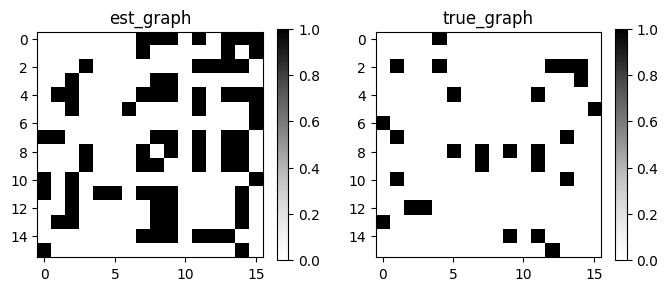

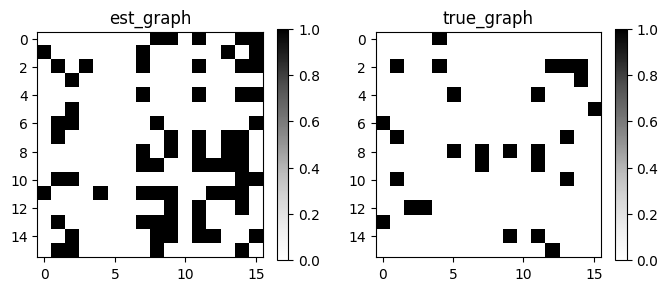

In [11]:
import time
import sys
import math
import numpy as np
import pandas as pd
from castle.common import GraphDAG
from castle.metrics import MetricsDAG

def to_summary(Rawdata, DataSize, true_dag):
    duration_anm_ncpop = []
    f1_anm_ncpop = []
    df = pd.DataFrame(columns=['fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'])
    for i in DataSize:
        data = Rawdata[:, :i, :]
        t_start = time.time()
        anmNCPO = ANM_NCPO(alpha=0.05)
        anmNCPO.learn(data = data)
        # plot predict_dag and true_dag
        GraphDAG(anmNCPO.causal_matrix, true_dag, show=False, save_name = File_PATH +file_name+'_' + str(i) + 'Datasize.png')
        met = MetricsDAG(anmNCPO.causal_matrix, true_dag)
        #f1_result.to_csv(self.File_PATH_Heatmaps + 'F1_'+self.sname+'.csv',index=False)
        if math.isnan(float(met.metrics['F1'])):
            f1_anm_ncpop.append(0.2)
        else:
            # print(math.isnan(met.metrics['F1']),met.metrics['F1']==np.nan)
            f1_anm_ncpop.append(met.metrics['F1'])
        print(file_name+'_' + str(i) + 'Datasize is done!'+'F1 Score is'+ str(met.metrics['F1'])+'.')
        print('Time Duration is'+ str(time.time()-t_start))
        duration_anm_ncpop.append(time.time()-t_start)
        df = pd.concat([df, pd.DataFrame([met.metrics])])
    df.to_csv(File_PATH +'Summary_Scores_' +file_name+'.csv', index=DataSize)
    df_F1 = pd.DataFrame({"DataSize":DataSize,'F1_Score':f1_anm_ncpop,'Duration':duration_anm_ncpop})
    #f1_result = df.loc[:, ['DataSize','F1_Score']]
    df_F1.to_csv(File_PATH + 'F1_Duration_'+file_name+'.csv',index=False)
    # return df, df_F1

def test_my_function(Rawdata, DataSize, true_dag):
    # 保存原始stdout
    original_stdout = sys.stdout
    # 重定向stdout到/dev/null或nul
    sys.stdout = open('/dev/null', 'w')  # Unix
    # sys.stdout = open('nul', 'w')  # Windows

    # 执行测试
    to_summary(Rawdata, DataSize, true_dag)

    # 恢复stdout
    sys.stdout = original_stdout

if __name__ == "__main__":
    ############################################################################################################
    ############################################ SETTING File_PATH and file_name ###############################
    ############################################################################################################

    File_PATH = "/content/drive/MyDrive/Colab Notebooks/NCPOP-Colab Notebooks/Test_Causality_Datasets/Real_data/Krebs_Cycle/"
    file_name = 'Krebs_Cycle_16_43_TS'
    # file_name = 'LinearGauss_6_15_TS'
    data = np.load(File_PATH+file_name+'.npz')
    Raw_data = data['x']
    true_dag = data['y']
    DataSize = range(3,5,1)
    Rawdata = Raw_data[:, :5, :6]
    test_my_function(Rawdata, DataSize, true_dag)

# Heatmap for testing synthetic data

# Backup

In [ ]:
class Ancpop_Real(object):
    '''
    A class for simulating random (causal) DAG, where any DAG generator
    self.method would return the weighed/binary adjacency matrix of a DAG.

    Parameters
    ----------
    File_PATH: str
        Save file path
    File_NAME: str
        Read data name
    start: int
        Start number of samples for standard trainning dataset
    stop: int
        stop number of samples for standard trainning dataset
    step: int
        step number of samples for standard trainning dataset

    '''
    def __init__(self, File_PATH,File_NAME, start, stop, step):
        self.File_PATH = File_PATH
        self.File_NAME = File_NAME
        self.start = start
        self.stop = stop
        self.step = step
        self.datasize = range(self.start, self.stop, self.step)
        self.datasize_num = len(self.datasize)
        self.sname = re.split("\.", self.File_NAME)[0]

    def Ancpop_real_Test(self):
        ################################################  Test Data #############################################
        self.File_PATH_Heatmaps = self.File_PATH + 'Results_'+self.sname+ '/'
        self.Table_PATH_Summary = self.File_PATH_Heatmaps + 'Summary_'+self.sname+'.csv'
        if not os.path.exists(self.Table_PATH_Summary):
            print('INFO: Testing '+ self.sname+'!')
            self.File_PATH_Base = self.File_PATH + 'Details_'+self.sname+ '/'
            self.Ancpop_real_estimate(self)
        else:
            print('INFO: Finished '+ self.sname+'Sampling!')

        ################################################  Create And Plot #############################################
        #self.Plots_ANCPOP_Real(self)
        print('INFO: Finished plotting '+ self.sname + '!')

    @staticmethod
    def Ancpop_real_estimate(self):
        read_Dir=os.listdir(self.File_PATH)
        if len(read_Dir) == 1:
            self.File_TYPE = re.split("\.", self.File_NAME)[1]
            if self.File_TYPE =='npz':
                print(self.File_TYPE)
                Tests_data = np.load(self.File_PATH+self.File_NAME, allow_pickle=True)
                Raw_data = Tests_data['x']
                true_dag = Tests_data['y']
                #print(Tests_data['x'][:20], Raw_data[:20],true_dag)
                #self.nodes_num = len(causal_matrix)
                #self.edges_num = len(causal_matrix[causal_matrix == 1])
            elif self.File_TYPE =='tar':
                Tests_data = np.load(self.File_NAME+'.tar', allow_pickle=True)
            else:
                print('INFO: Cannot Read '+self.File_TYPE+' Data!')
        else:
            Raw_data_path = self.File_PATH+read_Dir[0]
            Raw_data = pd.read_csv(Raw_data_path, header=0, index_col=0)
            DAG_data_path = self.File_PATH+read_Dir[1]
            DAG_data = pd.read_csv(DAG_data_path, header=0, index_col=0)


        ############################################## Create Files ###################################
        if not os.path.exists(self.File_PATH_Base):
            os.makedirs(self.File_PATH_Base)
        self.File_PATH_MetricsDAG = self.File_PATH_Base +'MetricsDAG/'
        if not os.path.exists(self.File_PATH_MetricsDAG):
            os.makedirs(self.File_PATH_MetricsDAG)
        if not os.path.exists(self.File_PATH_Heatmaps):
            os.makedirs(self.File_PATH_Heatmaps)

        duration_anm_ncpop = []
        f1_anm_ncpop = []
        df = pd.DataFrame(columns=['fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'])

        #df = pd.DataFrame(columns=['DataSize','False_Discovery_Rate', 'True_Positive_Rate', 'False_Positive_Rate', 'SHD', 'NNZ', 'Precision', 'Recall', 'F1_Score', 'G_score'])
        for i in self.datasize:
            data = Raw_data[:i]
            t_start = time.time()
            anmNCPO = ANM_NCPO(alpha=0.05)
            anmNCPO.learn(data = data)
            # plot predict_dag and true_dag
            GraphDAG(anmNCPO.causal_matrix, true_dag, show=False, save_name = self.File_PATH_MetricsDAG+self.sname+'_' + str(i) + 'Datasize.png')
            met = MetricsDAG(anmNCPO.causal_matrix, true_dag)
            #f1_result.to_csv(self.File_PATH_Heatmaps + 'F1_'+self.sname+'.csv',index=False)
            if math.isnan(float(met.metrics['F1'])):
              f1_anm_ncpop.append(0.2)
            else:
              print(math.isnan(met.metrics['F1']),met.metrics['F1']==np.nan)
              f1_anm_ncpop.append(met.metrics['F1'])
            duration_anm_ncpop.append(time.time()-t_start)
            print(self.sname+'_' + str(i) + 'Datasize is done!'+'F1 Score is'+ str(met.metrics['F1'])+'.')
            #'Time Duration is'+ str(time.time()-t_start))
            df = pd.concat([df, pd.DataFrame([met.metrics])])
        df.to_csv(self.Table_PATH_Summary, index=False)
        #df = pd.concat({"DataSize":[self.datasize]},{df.loc[:, ['F1']]})
        df_F1 = pd.DataFrame({"DataSize":self.datasize,'F1_Score':f1_anm_ncpop,'Duration':duration_anm_ncpop})
        #f1_result = df.loc[:, ['DataSize','F1_Score']]
        df_F1.to_csv(self.File_PATH_Heatmaps + 'F1_'+self.sname+'.csv',index=False)
        return df_F1

    '''
    @staticmethod
    def Summary_Results(self):
        f1_anm_ncpop = pd.DataFrame()
        tqdm=os.listdir(self.File_PATH_Details)
        for i in range(0,len(tqdm)):
            File_PATH = os.path.join(self.File_PATH_Details,tqdm[i])
            #ds = re.split("D",re.split("edges_",re.split("nodes_", re.split("\.", tqdm[i])[0])[1])[1])[0]
            df = pd.read_csv(File_PATH)
            f1_anm_ncpop_nan = df.loc[:,'F1']
            if len([f1_anm_ncpop_nan == 0]) == len(f1_anm_ncpop_nan):
              f1_anm_ncpop_mean = 0.2
            else:
              f1_anm_ncpop_mean = round(np.nanmean(f1_anm_ncpop_nan), 3)
            f1_anm_ncpop = pd.concat((f1_anm_ncpop, pd.DataFrame([ds, f1_anm_ncpop_mean])), axis=1)
        f1_result = pd.DataFrame(np.array(f1_anm_ncpop.T), columns=['Linear','Gauss','Nodes','Edges','DataSize','F1_Score'])
        f1_result.to_csv(self.Table_PATH_Summary,index=False)
        return f1_result'''

    @staticmethod
    def Plots_ANCPOP_Real(self):
        self.pro_rang = np.arange(self.start, self.stop, self.step)
        self.obs_rang = np.arange(self.start, self.stop, self.step)
        fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,20))
        z =[]
        zz = pd.read_csv(self.File_PATH_Heatmaps + 'F1_'+self.sname+'.csv', header=[1], index_col=0)
        z = zz.to_numpy()
        z_min=np.min(z)
        z_max=np.max(z)
        c = axes.imshow(z, cmap =plt.cm.bone_r, vmin = z_min, vmax = z_max,
                        interpolation ='nearest', origin ='upper')
        axes.set_xlabel('length of time windows '+r'$T$',fontsize=10)
        #axes.set_ylabel('F1 score ',fontsize=10)
        positions = range(9)
        labels=self.datasize
        axes.yaxis.set_major_locator(ticker.FixedLocator(positions))
        axes.yaxis.set_major_formatter(ticker.FixedFormatter(labels))
        for ytick in axes.get_yticklabels():
            ytick.set_fontsize(4)
        axes.xaxis.set_major_locator(ticker.FixedLocator(positions))
        axes.xaxis.set_major_formatter(ticker.FixedFormatter(labels))
        for xtick in axes.get_xticklabels():
            xtick.set_fontsize(4)

        fig.colorbar(c, ax=axes.ravel().tolist())
        plt.savefig(self.File_PATH_Heatmaps +'Heatmap_ '+self.sname+'.pdf', bbox_inches='tight')


# ANM-NCPOP

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from itertools import combinations
from castle.common import BaseLearner, Tensor
from castle.common.independence_tests import hsic_test
# from inputlds import*
# from functions import*
from ncpol2sdpa import*
from math import sqrt


class NCPOLR(object):
    """Estimator based on NCPOP Regressor

    References
    ----------
    Quan Zhou https://github.com/Quan-Zhou/Proper-Learning-of-LDS/blob/master/ncpop/functions.py

    Examples
    --------
    """

    def __init__(self, **kwargs):
        super(NCPOLR, self).__init__()

    def estimate(self, X, Y):
        """Fit Estimator based on NCPOP Regressor model and predict y or produce residuals.
        The module converts a noncommutative optimization problem provided in SymPy
        format to an SDPA semidefinite programming problem.

        Parameters
        ----------
        X : array
            Variable seen as cause
        Y: array
            Variable seen as effect

        Returns
        -------
        y_predict: array
            regression predict values of y or residuals
        """

        T = len(Y)
        level = 1

        # Decision Variables
        G = generate_operators("G", n_vars=1, hermitian=True, commutative=False)[0]
        f = generate_operators("f", n_vars=T, hermitian=True, commutative=False)
        n = generate_operators("m", n_vars=T, hermitian=True, commutative=False)
        p = generate_operators("p", n_vars=T, hermitian=True, commutative=False)

        # Objective
        obj = sum((Y[i]-f[i])**2 for i in range(T)) + 0.00005*sum(p[i] for i in range(T))

        # Constraints
        ine1 = [f[i] - G*X[i] - n[i] for i in range(T)]
        ine2 = [-f[i] + G*X[i] + n[i] for i in range(T)]
        ine3 = [p[i]-n[i] for i in range(T)]
        ine4 = [p[i]+n[i] for i in range(T)]
        ines = ine1+ine2+ine3+ine4

        # Solve the NCPO
        sdp = SdpRelaxation(variables = flatten([G,f,n,p]),verbose = 1)
        sdp.get_relaxation(level, objective=obj, inequalities=ines)
        sdp.solve(solver='mosek')
        #sdp.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:/Users/zhouq/Documents/sdpa7-windows/sdpa.exe"})
        print(sdp.primal, sdp.dual, sdp.status)

        if(sdp.status != 'infeasible'):
            print('ok.')
            est_noise = []
            for i in range(T):
                est_noise.append(sdp[n[i]])
            print(est_noise)
            return est_noise
        else:
            print('Cannot find feasible solution.')
            return

    def estimate2(self, X, Y):
        """Fit Estimator based on NCPOP Regressor model and predict y or produce residuals.
        The module converts a noncommutative optimization problem provided in SymPy
        format to an SDPA semidefinite programming problem.

        Parameters
        ----------
        Y: array
            Variable seen as effect

        Returns
        -------
        y_predict: array
            regression predict values of y or residuals
        """
        Y = np.transpose(Y)
        T = len(Y)-1
        level = 1


        # Decision Variables
        G = generate_operators("G", n_vars=1, hermitian=True, commutative=False)[0]
        Fdash = generate_operators("Fdash", n_vars=1, hermitian=True, commutative=False)[0]
        # m = generate_operators("m", n_vars=T+1, hermitian=True, commutative=False)
        q = generate_operators("q", n_vars=T, hermitian=True, commutative=False)
        p = generate_operators("p", n_vars=T, hermitian=True, commutative=False)
        f = generate_operators("f", n_vars=T, hermitian=True, commutative=False)

        # Objective
        obj = sum((Y[i]-f[i])**2 for i in range(T)) + 0.0005*sum(p[i]**2 for i in range(T)) + 0.001*sum(q[i]**2 for i in range(T))

        #c1*sum(p[i]**2 for i in range(T)) + c2*sum(q[i]**2 for i in range(T))

        # Constraints
        ine1 = [f[i] - Fdash*X[i+1] - p[i] for i in range(T)]
        ine2 = [-f[i] + Fdash*X[i+1] + p[i] for i in range(T)]
        ine3 = [X[i+1] - G*X[i] - q[i] for i in range(T)]
        ine4 = [-X[i+1] + G*X[i] + q[i] for i in range(T)]
        #ine5 = [(Y[i]-f[i])**2 for i in range(T)]
        ines = ine1+ine2+ine3+ine4 #+ine5

        # Solve the NCPO
        sdp = SdpRelaxation(variables = flatten([G,Fdash,f,p,q]),verbose = 1)
        sdp.get_relaxation(level, objective=obj, inequalities=ines)
        sdp.solve(solver='mosek')

        #sdp.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:/Users/zhouq/Documents/sdpa7-windows/sdpa.exe"})
        print(sdp.primal, sdp.dual, sdp.status)

        if(sdp.status != 'infeasible'):
            print('ok.')
            est_noise = []
            for i in range(T):
                est_noise.append(sdp[p[i]])
            print(est_noise)
            return est_noise, X[1:]
        else:
            print('Cannot find feasible solution.')
            return


In [ ]:
class ANM_NCPO(BaseLearner):
    """
    Nonlinear causal discovery with additive noise models

    Use Estimator based on NCPOP Regressor and independent Gaussian noise,
    For the independence test, we implemented the HSIC with a Gaussian kernel,
    where we used the gamma distribution as an approximation for the
    distribution of the HSIC under the null hypothesis of independence
    in order to calculate the p-value of the test result.

    References
    ----------
    Hoyer, Patrik O and Janzing, Dominik and Mooij, Joris M and Peters,
    Jonas and Schölkopf, Bernhard,
    "Nonlinear causal discovery with additive noise models", NIPS 2009

    Parameters
    ----------
    alpha : float, default 0.05
        significance level be used to compute threshold

    Attributes
    ----------
    causal_matrix : array like shape of (n_features, n_features)
        Learned causal structure matrix.

    Examples
    --------
    """

    def __init__(self, alpha=0.05):
        super(ANM_NCPO, self).__init__()
        self.alpha = alpha

    def learn(self, data, columns=None, regressor=NCPOLR(),test_method=hsic_test, **kwargs):
        """Set up and run the ANM_NCPOP algorithm.

        Parameters
        ----------
        data: numpy.ndarray or Tensor
            Training data.
        columns : Index or array-like
            Column labels to use for resulting tensor. Will default to
            RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
        regressor: Class
            Nonlinear regression estimator, if not provided, it is NCPOLR.
            If user defined, must implement `estimate` self.method. such as :
                `regressor.estimate(x, y)`
        test_method: callable, default test_method
            independence test self.method, if not provided, it is HSIC.
            If user defined, must accept three arguments--x, y and keyword
            argument--alpha. such as :
                `test_method(x, y, alpha=0.05)`
        """

        self.regressor = regressor

        # create learning model and ground truth model
        data = Tensor(data, columns=columns)

        node_num = data.shape[0]
        self.causal_matrix = Tensor(np.zeros((node_num, node_num)))

        for i, j in combinations(range(node_num), 2):
            x = data[i, :, :]
            y = data[j, :, :]
            xx = x.reshape(-1,1)
            yy = y.reshape(-1,1)

            flag = test_method(xx, yy, alpha=self.alpha)
            if flag == 1:
                continue
            # test x-->y
            flag = self.ANMNCPO_fitness(x, y, regressor = regressor, test_method=test_method)
            if flag:
                self.causal_matrix[i, j] = 1
            # test y-->x
            flag = self.ANMNCPO_fitness(y, x, regressor = regressor, test_method=test_method)
            if flag:
                self.causal_matrix[j, i] = 1

    def ANMNCPO_fitness(self, x, y, regressor=NCPOLR(), test_method=hsic_test):
        """Compute the fitness score of the ANM_NCPOP Regression model in the x->y direction.

        Parameters
        ----------
        x: array
            Variable seen as cause
        y: array
            Variable seen as effect
        regressor: Class
            Nonlinear regression estimator, if not provided, it is NCPOP.
            If user defined, must implement `estimate` self.method. such as :
                `regressor.estimate(x, y)`
        test_method: callable, default test_method
            independence test self.method, if not provided, it is HSIC.
            If user defined, must accept three arguments--x, y and keyword
            argument--alpha. such as :
                `test_method(x, y, alpha=0.05)`
        Returns
        -------
        out: int, 0 or 1
            If 1, residuals n is independent of x, then accept x --> y
            If 0, residuals n is not independent of x, then reject x --> y

        """

        x = scale(x).reshape(-1)
        y = scale(y).reshape(-1)

        ncpop_res = regressor.estimate2(x, y)
        print(x)
        print(y)

        flag = test_method(np.asarray(ncpop_res[0]).reshape((-1, 1)), np.asarray(ncpop_res[1]).reshape((-1, 1)), alpha=self.alpha)

        print(flag)

        return flag



In [ ]:
if __name__ == "__main__":
    ############################################################################################################
    ############################################ SETTING File_PATH and file_name ###############################
    ############################################################################################################

    File_PATH = "/content/drive/MyDrive/Colab Notebooks/NCPOP-Colab Notebooks/Test_Causality_Datasets/Real_data/Krebs_Cycle/"
    file_name = 'LinearGauss_6_15'
    data = np.load(File_PATH+file_name+'.npz')
    Raw_data = data['x']
    true_dag = data['y']
    # print(Raw_data.shape, true_dag.shape)
    X = Raw_data[:10,]

In [ ]:
x = X[:,0]
y = X[:,1]
anmNCPO = ANM_NCPO(alpha=0.05)
anmNCPO.ANMNCPO_fitness(x, y, regressor = NCPOLR(), test_method=hsic_test)

[ 0.86653643  0.69823488 -0.51156086  0.10436835 -1.45729735  1.27956373
 -0.9025051   2.20115662 -3.57053799  0.78085863]
[ 1.92383191  0.99109127  0.3806108  -0.74776636 -1.3176775   1.33291008
 -0.68454025  1.25598233  0.49672635  0.3292758 ]
The problem has 31 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 527
Generating moment matrix...
Reduced number of SDP variables: 527
Processing 10/40 constraints...

Processing 40/40 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 527             
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 2628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

1